## Load libraries

In [1]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data

# Libraries to cluster data
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.utils import ClippedCorpus

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from pprint import pprint
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
from cluster_visualization_helper import visualize_cluster, compute_cluster_visualization  # user-defined functions

# Libraries for evaluation
from gensim.models import CoherenceModel

# Libraries for monitoring operation process
from tqdm import tqdm

## Configurate and declare global variables

In [2]:
os_name = os.name

if os_name == 'nt':
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
elif os_name == 'posix':
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"

SEED = 6886

%matplotlib inline

## Import data

In [3]:
title_docs = pd.read_csv(OUTPUT_DIR + "title_docs.csv")

## Convert data to correct type

In [4]:
title_docs["clean_job_title"] = title_docs["clean_job_title"].apply(ast.literal_eval)

In [7]:
title_docs["clean_job_title"]

0                              [chief, financial, officer]
1        [full, time, community, connection, intern, pa...
2                                   [country, coordinator]
3                                        [bcc, specialist]
4                                    [software, developer]
                               ...                        
18987                 [senior, creative, ux, ui, designer]
18988                     [category, development, manager]
18989                    [operational, marketing, manager]
18990                     [head, online, sale, department]
18991                          [lawyer, legal, department]
Name: clean_job_title, Length: 18992, dtype: object

Text(0.5, 1.0, 'Distribution of word count in the job title')

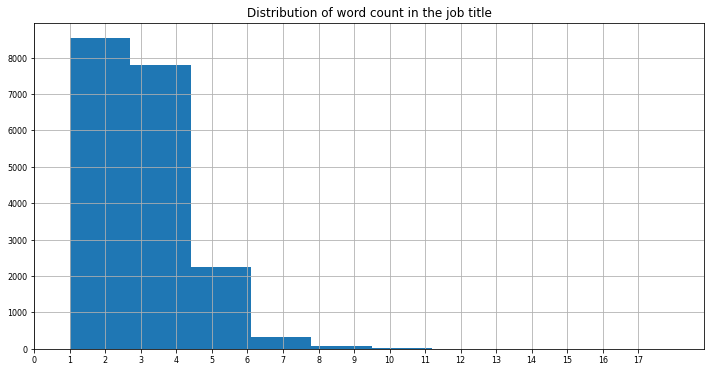

In [8]:
title_docs["word_count"] = title_docs["clean_job_title"].apply(lambda x: len(x))
title_docs[["word_count"]].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8)
plt.xticks(list(range(max(title_docs["word_count"].values))))
plt.title("Distribution of word count in the job title")

## Clustering data

### Latent Dirichlet Allocation (LDA) 

In [9]:
# Create doc list of clean job titles
doc_list = [
    " ".join(doc) for doc in title_docs["clean_job_title"].values.tolist()
]
pprint(doc_list[:10])

# Create corpus (list of tokens per document)
title_corpus = title_docs["clean_job_title"].values.tolist()
pprint(title_corpus[:10])

# Create Dictionary
id2word = Dictionary(title_corpus)

# Term Document Frequency
lda_corpus = [id2word.doc2bow(text) for text in title_corpus]
pprint(lda_corpus[:3])

['chief financial officer',
 'full time community connection intern pay internship',
 'country coordinator',
 'bcc specialist',
 'software developer',
 'saleswoman',
 'chief accountant finance assistant',
 'non pay part full time programmatic intern',
 'assistant manage director',
 'program assistant inl fsn fp']
[['chief', 'financial', 'officer'],
 ['full', 'time', 'community', 'connection', 'intern', 'pay', 'internship'],
 ['country', 'coordinator'],
 ['bcc', 'specialist'],
 ['software', 'developer'],
 ['saleswoman'],
 ['chief', 'accountant', 'finance', 'assistant'],
 ['non', 'pay', 'part', 'full', 'time', 'programmatic', 'intern'],
 ['assistant', 'manage', 'director'],
 ['program', 'assistant', 'inl', 'fsn', 'fp']]
[[(0, 1), (1, 1), (2, 1)],
 [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(10, 1), (11, 1)]]


In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in lda_corpus[:3]]

[[('chief', 1), ('financial', 1), ('officer', 1)],
 [('community', 1),
  ('connection', 1),
  ('full', 1),
  ('intern', 1),
  ('internship', 1),
  ('pay', 1),
  ('time', 1)],
 [('coordinator', 1), ('country', 1)]]

In [11]:
def build_lda_model(dictionary, corpus, k, a, b):
    """
    Build LDA Topic model

    Parameters:
    ----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    k: number of topics
    a: Dirichlet hyperparameter alpha (Document-Topic Density)
    b: Dirichlet hyperparameter beta (Word-Topic Density)

    Returns:
    -------
    model: LDA topic models
    """

    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=100,
        update_every=1,
        chunksize=1000,
        passes=10,
        alpha=a,
        eta=b,
        iterations=100
    )

    return model

In [12]:
def compute_evaluation_metrics(model, corpus, dictionary, texts):
    """
    Compute c_v coherence and perplexity for various number of topics

    Parameters:
    ----------
    model: LDA topic model
    corpus: Gensim corpus
    dictionary: Gensim dictionary
    texts: List of input texts

    Returns:
    -------
    coherence_value: Coherence value corresponding to the LDA model with respective number of topics
    perplexity_value: Perplexity value corresponding to the LDA model with respective number of topics
    """

    coherencemodel = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence="c_v"
    )

    perplexity_value = model.log_perplexity(corpus)
    coherence_value = coherencemodel.get_coherence()

    return coherence_value, perplexity_value

In [23]:
# Preparing hyperparameters for tuning
grid = {}
grid["Validation_Set"] = {}

# Topics range
min_topics = 2
max_topics = 101
step_size = 10
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 2, 0.5))
alpha.append("symmetric")
alpha.append("asymmetric")

# Beta parameter
beta = list(np.arange(0.01, 2, 0.5))
beta.append("symmetric")

# Validation sets
num_of_docs = len(lda_corpus)
corpus_sets = [ClippedCorpus(lda_corpus, int(num_of_docs * 0.75)), lda_corpus]
corpus_title = ["75% Corpus", "100% Corpus"]
model_results = {
    "Validation_Set_no": [],
    "Validation_Set": [],
    "Topics": [],
    "Alpha_num": [],
    "Alpha": [],
    "Beta_num": [],
    "Beta": [],
    "Coherence": [],
    "Perplexity": []
}

In [24]:
len(corpus_sets) * len(topics_range) * len(alpha) * len(beta)

600

In [28]:
# Tuning LDA to find optimal number of topics
pbar = tqdm(
    desc="LDA tuning",
    total=len(corpus_sets) * len(topics_range) * len(alpha) * len(beta),
)

# iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for ida, a in enumerate(alpha):
            # iterare through beta values
            for idb, b in enumerate(beta):
                # get the coherence score and perplexity for the given parameters
                lda_model = build_lda_model(
                    dictionary=id2word, corpus=corpus_sets[i], k=k, a=a, b=b
                )
                cv_score, perplexity = compute_evaluation_metrics(
                    lda_model,
                    corpus=corpus_sets[i],
                    dictionary=id2word,
                    texts=title_corpus,
                )

                # Save the model results
                model_results["Validation_Set_no"].append(i)
                model_results["Validation_Set"].append(corpus_title[i])
                model_results["Topics"].append(k)
                model_results["Alpha_num"].append(ida)
                model_results["Alpha"].append(a)
                model_results["Beta_num"].append(idb)
                model_results["Beta"].append(b)
                model_results["Coherence"].append(cv_score)
                model_results["Perplexity"].append(perplexity)

                pbar.update(1)

model_results_df = pd.DataFrame(model_results)
model_results_df.to_csv(OUTPUT_DIR + "lda_tuning_results.csv", index=False)
pbar.close()



LDA tuning:   0%|                                                                              | 0/600 [00:00<?, ?it/s]

LDA tuning:   0%|                                                                    | 1/600 [00:19<3:12:20, 19.27s/it]

LDA tuning:   0%|▏                                                                   | 2/600 [00:39<3:19:54, 20.06s/it]

LDA tuning:   0%|▎                                                                   | 3/600 [01:00<3:22:53, 20.39s/it]

LDA tuning:   1%|▍                                                                   | 4/600 [01:21<3:25:05, 20.65s/it]

LDA tuning:   1%|▌                                                                   | 5/600 [01:42<3:26:08, 20.79s/it]

LDA tuning:   1%|▋                                                                   | 6/600 [02:03<3:25:06, 20.72s/it]

LDA tuning:   1%|▊                                                                   | 7/600 [02:24<3:24:39, 20.71s/it]

LDA tuning:   1%|▉            

In [ ]:
# np.random.seed(SEED)

# for c in alpha:
#     if str(c).isalpha():
#         rd = np.random.rand()
#         while rd == c:
#             rd = np.random.rand()
#         model_results_df.loc[model_results_df['Alpha'] == c, ['Alpha_num']] = rd

# model_results_df

In [124]:
# np.random.seed(SEED)

# for c in beta:
#     if str(c).isalpha():
#         rd = np.random.rand()
#         while rd == c:
#             rd = np.random.rand()
#         model_results_df.loc[model_results_df['Beta'] == c, ['Beta_num']] = rd
# model_results_df

In [ ]:
# list = []
# for i in range(len(corpus_sets)):
#     list1 = [i]*(len(topics_range) * len(alpha) * len(beta))
#     list.extend(list1)
# model_results_df['Validation_Set_no'] = list
# model_results_df

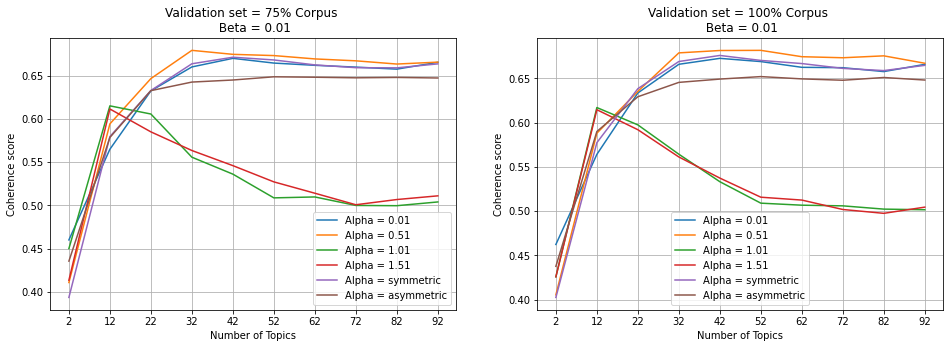

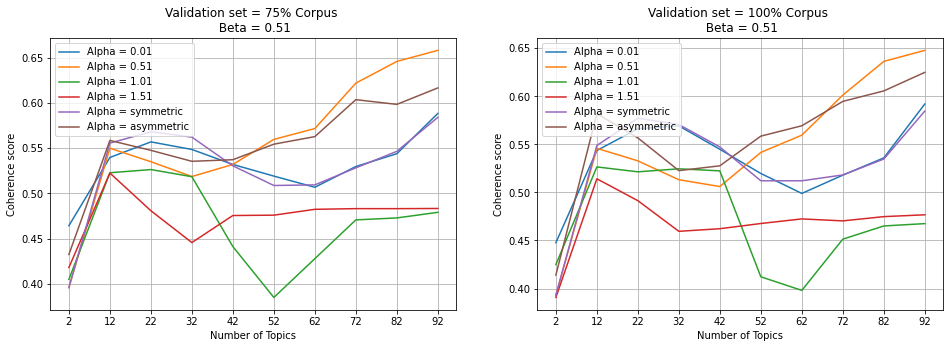

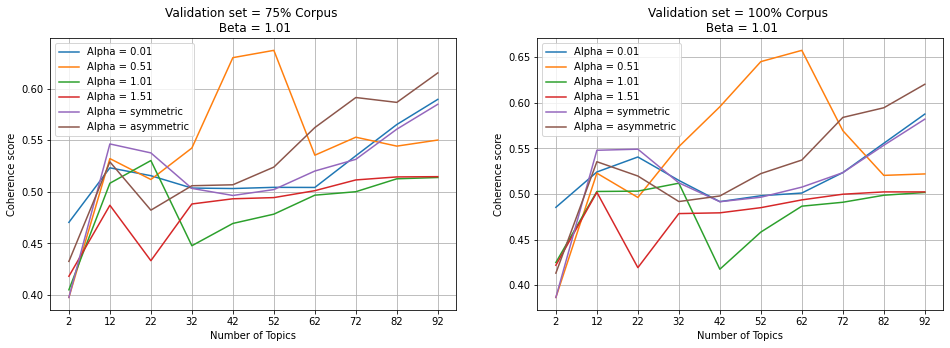

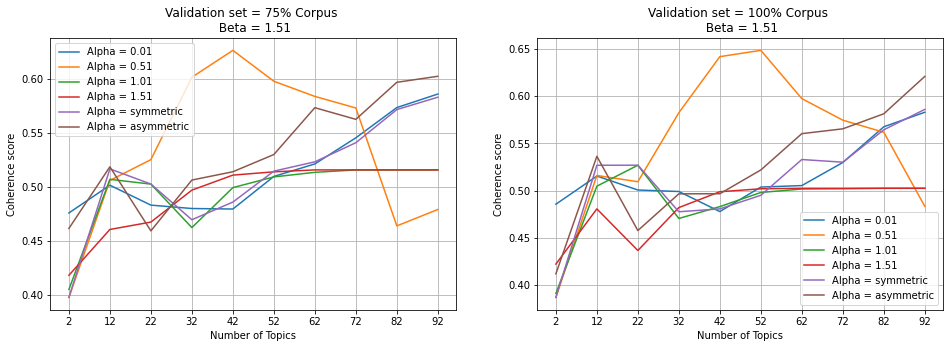

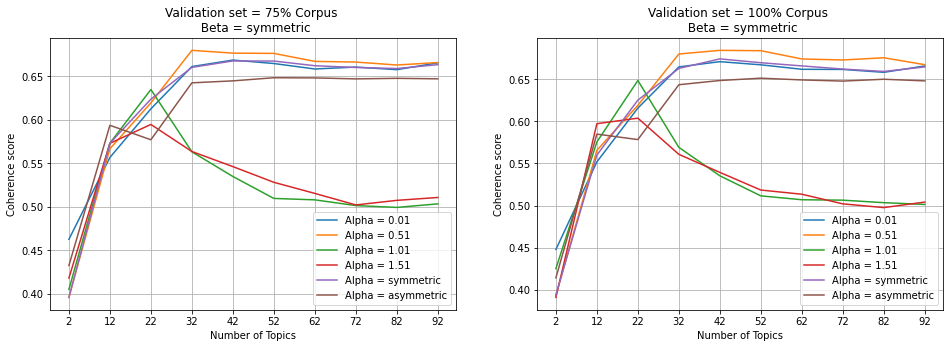

In [45]:
# Draw graph of Coherence values
for b in beta:
    plt.figure(figsize=(16, 5))
    for ids, s in zip(range(len(corpus_sets)), corpus_title):
        plot_df = model_results_df.loc[model_results_df["Beta"] == b]
        plot_df = plot_df.loc[plot_df['Validation_Set_no'] == ids]
        plt.subplot(1, len(corpus_sets), ids+1)
        for a in alpha:
            plt.plot(
                plot_df["Topics"].loc[plot_df['Alpha'] == a],
                plot_df["Coherence"].loc[plot_df['Alpha'] == a],
                label=f"Alpha = {a}",
            )
        plt.title(f"Validation set = {s} \n Beta = {b}")
        plt.legend(loc="best")
        plt.xlabel("Number of Topics")
        plt.xticks(topics_range)
        plt.ylabel("Coherence score")
        plt.grid()
    plt.show()

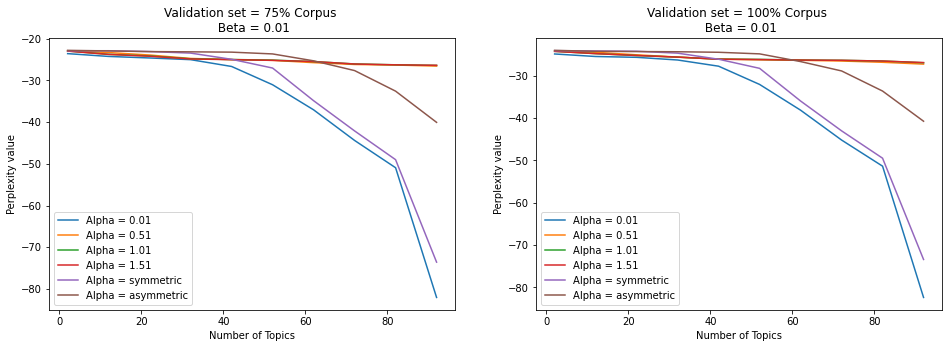

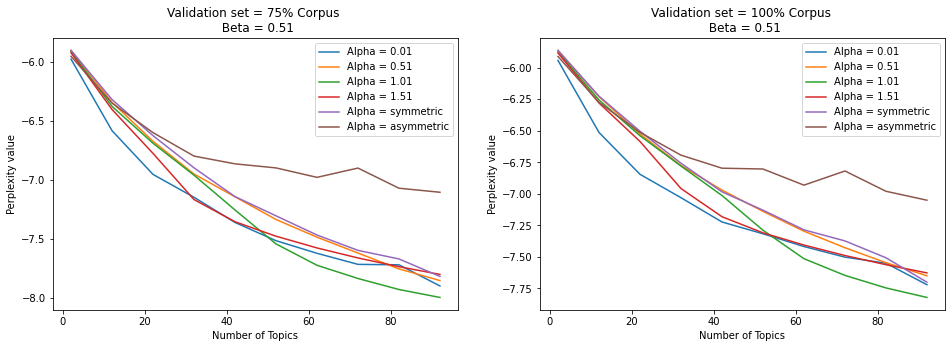

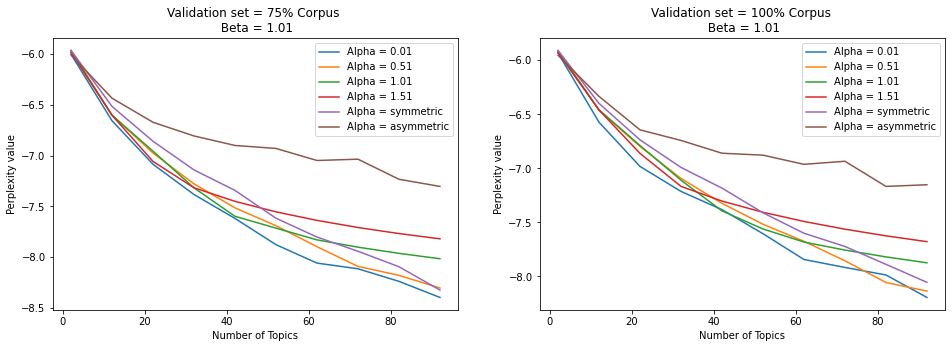

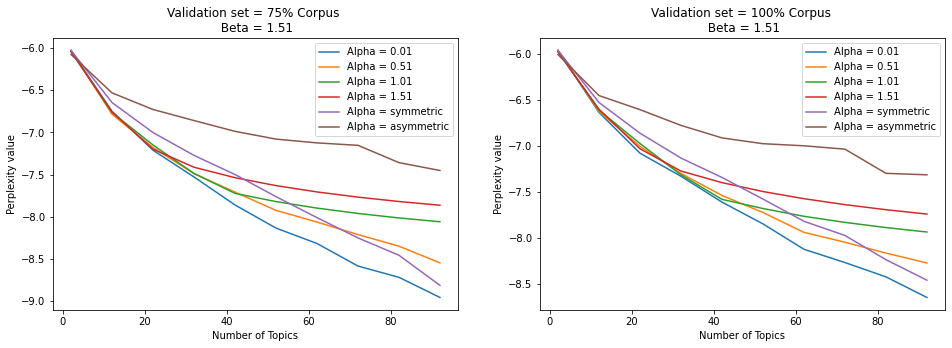

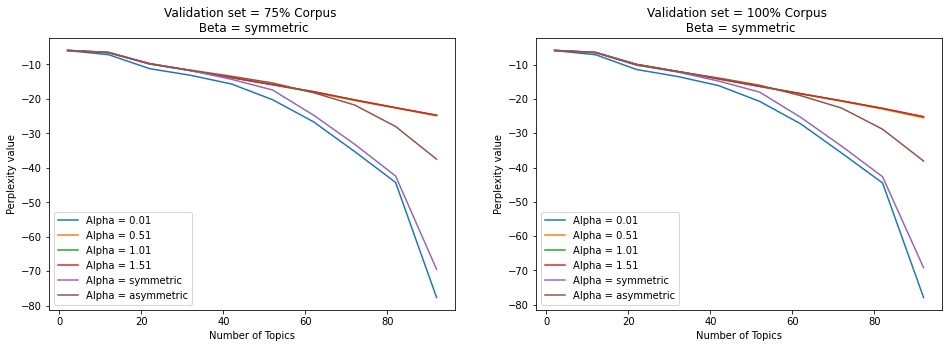

In [43]:
# Draw graph of Perplexity values (The lower the better)
for b in beta:
    plt.figure(figsize=(16, 5))
    for ids, s in zip(range(len(corpus_sets)), corpus_title):
        plot_df = model_results_df.loc[model_results_df["Beta"] == b]
        plot_df = plot_df.loc[plot_df['Validation_Set_no'] == ids]
        plt.subplot(1, len(corpus_sets), ids+1)
        for a in alpha:
            plt.plot(
                plot_df["Topics"].loc[plot_df['Alpha'] == a],
                plot_df["Perplexity"].loc[plot_df['Alpha'] == a],
                label=f"Alpha = {a}",
            )
        plt.title(f"Validation set = {s} \n Beta = {b}")
        plt.legend(loc="best")
        plt.xlabel("Number of Topics")
        plt.ylabel("Perplexity value")
    plt.show()

In [47]:
np.argmax(model_results_df['Coherence'].values), np.max(model_results_df['Coherence'].values)

(430, 0.6844766663043175)

In [48]:
model_results_df.loc[430]

Validation_Set_no              1
Validation_Set       100% Corpus
Topics                        42
Alpha_num                      1
Alpha                       0.51
Beta_num                       4
Beta                   symmetric
Coherence               0.684477
Perplexity            -14.257697
Name: 430, dtype: object

In [49]:
# Select the LDA model with optimal number of topics
best_index = np.argmax(model_results_df["Coherence"].values)
best_num_topics = model_results_df["Topics"].loc[best_index]
best_alpha = model_results_df["Alpha"].loc[best_index]
best_beta = model_results_df["Beta"].loc[best_index]

print(
    f"Optimal number of topics = {best_num_topics}, best alpha = {best_alpha}, best beta = {best_beta}"
)
best_lda_model = build_lda_model(
    dictionary=id2word, corpus=lda_corpus, k=best_num_topics, a=best_alpha, b=best_beta
)

Optimal number of topics = 42, best alpha = 0.51, best beta = symmetric


In [60]:
# Get topic weights
topic_weights = []
for i, row_list in tqdm(enumerate(best_lda_model[lda_corpus])):
#     print(i)
#     pprint(row_list)
#     print(row_list[0])
    topic_weights.append([w for i, w in row_list])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [62]:
np.asarray(topic_weights).shape

(18992, 42)

In [65]:
np.asarray(topic_weights)[:2, :]

array([[0.02088454, 0.02088454, 0.02088454, 0.02088454, 0.02088454,
        0.02088454, 0.02088454, 0.02088454, 0.02088454, 0.02088454,
        0.02088454, 0.02088454, 0.02088454, 0.02088454, 0.02088454,
        0.02088454, 0.02088454, 0.02088454, 0.02088454, 0.02088454,
        0.02088454, 0.02088454, 0.02088454, 0.02088454, 0.02088454,
        0.02088454, 0.02088454, 0.02088454, 0.02088454, 0.06183439,
        0.06183428, 0.02088454, 0.02088454, 0.02088454, 0.02088454,
        0.02088454, 0.02088454, 0.06183433, 0.02088454, 0.02088454,
        0.02088454, 0.02088454],
       [0.02088471, 0.02088471, 0.02088471, 0.02088471, 0.02088471,
        0.02088471, 0.02088471, 0.02088471, 0.02088471, 0.02088471,
        0.06183479, 0.02088471, 0.02088471, 0.02088471, 0.02088471,
        0.02088471, 0.02088471, 0.02088471, 0.06182909, 0.02088471,
        0.02088471, 0.02088471, 0.02088471, 0.02088471, 0.02088471,
        0.02088471, 0.06183248, 0.02088471, 0.02088471, 0.02088471,
        0.02088

In [67]:
np.unique(topic_num)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41], dtype=int64)

In [68]:
# Reduce dimensionality using t-SNE algorithm
pca_datapoint, tsne_datapoint = compute_cluster_visualization(
    arr, pca=True, tsne=True, seed=SEED
)

Start PCA 2021-04-27 20:51:56.871239
End PCA 2021-04-27 20:51:56.983239
PCA duration 0:00:00.112000
Start t-SNE 2021-04-27 20:51:56.983239
End t-SNE 2021-04-27 20:53:57.090297
t-SNE duration 0:02:00.107058


In [69]:
## Save PCA and t-SNE dimensionality reduced data to file
np.save(OUTPUT_DIR + "lda_pca_datapoints", pca_datapoint)
np.save(OUTPUT_DIR + "lda_tsne_datapoints", tsne_datapoint)

Start PCA 2021-04-27 20:55:37.815805
End PCA 2021-04-27 20:55:37.829806
PCA duration 0:00:00.014001

Start t-SNE 2021-04-27 20:55:37.829806
End t-SNE 2021-04-27 20:55:37.833807
t-SNE duration 0:00:00.004001

Wall time: 182 ms


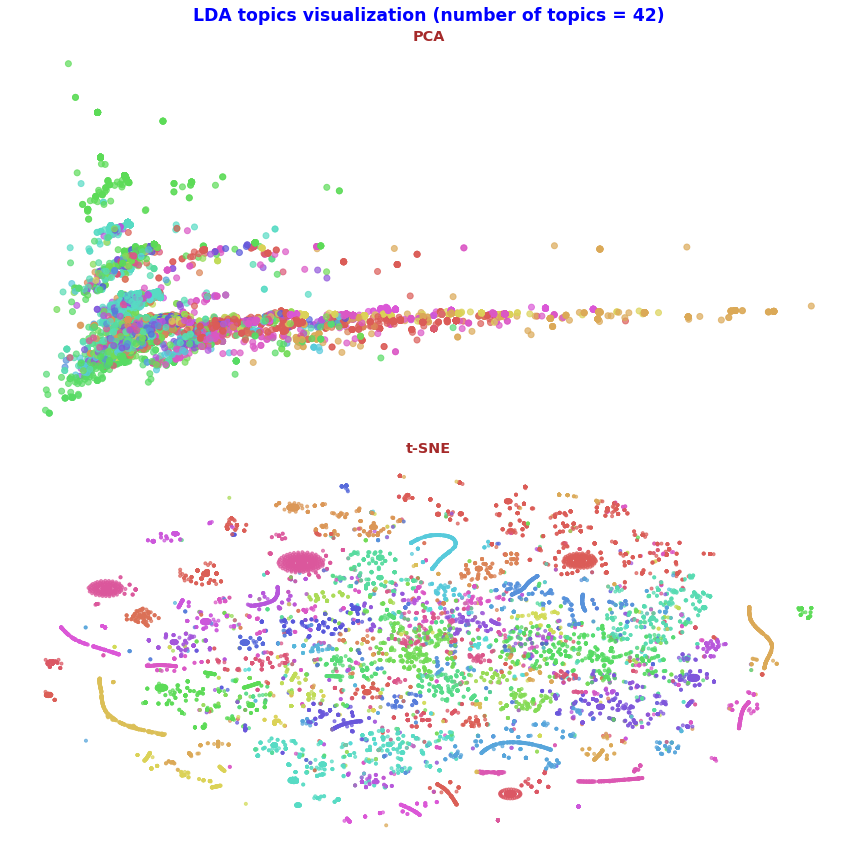

In [70]:
%%time
plot_title = f"LDA topics visualization (number of topics = {best_num_topics})"
palette = sns.color_palette("hls", as_cmap=True)
colors = topic_num / best_num_topics

# Visualize clusters with PCA and t-SNE
visualize_cluster(plot_title, (12,12), colors, palette, pca_datapoint, tsne_datapoint, pca=True, tsne=True)

In [72]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=best_lda_model, corpus=lda_corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]),
                    ignore_index=True,
                )
            else:
                break
    sent_topics_df.columns = ["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(
    ldamodel=best_lda_model, corpus=lda_corpus, texts=doc_list
)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,29.0,0.0618,"officer, national, programme, general, linux, ...",chief financial officer
1,1,10.0,0.0618,"intern, design, network, audit, electrical, wo...",full time community connection intern pay inte...
2,2,18.0,0.0645,"coordinator, technical, support, education, jo...",country coordinator
3,3,21.0,0.0640,"specialist, management, component, hardware, y...",bcc specialist
4,4,4.0,0.0645,"software, c, java, responsible, professional, ...",software developer
5,5,0.0,0.0238,"web, translator, international, driver, interp...",saleswoman
6,6,37.0,0.0987,"accountant, chief, train, telecommunication, h...",chief accountant finance assistant
7,7,10.0,0.0618,"intern, design, network, audit, electrical, wo...",non pay part full time programmatic intern
8,8,19.0,0.0618,"assistant, supervisor, construction, merchandi...",assistant manage director
9,9,19.0,0.0645,"assistant, supervisor, construction, merchandi...",program assistant inl fsn fp


In [73]:
# Find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorted_df = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in tqdm(sent_topics_outdf_grpd):
    sent_topics_sorted_df = pd.concat(
        [
            sent_topics_sorted_df,
            grp.sort_values(["Perc_Contribution"], ascending=[0]).head(1),
        ],
        axis=0,
    )

# Reset Index
sent_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df.columns = [
    "Topic_Num",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

# Show
sent_topics_sorted_df.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1437,"web, translator, international, driver, interp...",persian armenian translator interpreter
1,1.0,0.1072,"team, leader, reporting, beverage, manager, no...",team leader
2,2.0,0.1437,"internal, auditor, quality, center, assurance,...",quality assurance auditor
3,3.0,0.2009,"language, english, course, secretary, writer, ...",technical writer native english language capab...
4,4.0,0.1381,"software, c, java, responsible, professional, ...",c c software engineer
5,5.0,0.1003,"manager, care, civil, advocacy, seller, russia...",beauty care brand manager
6,6.0,0.1660,"developer, net, asp, clerk, family, psychologi...",senior asp asp net developer
7,7.0,0.1057,"market, economic, advertising, south, internet...",market advertising manager
8,8.0,0.1381,"procurement, application, architect, field, tr...",van salesman trade agent confectionery
9,9.0,0.0987,"finance, manager, supply, rural, ict, ba, amsg...",director rural finance facility rff


In [82]:
# Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords["Dominant_Topic"].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts / topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[["Dominant_Topic", "Topic_Keywords"]]

# Concatenate Column wise
df_dominant_topics = pd.concat(
    [topic_num_keywords, topic_counts, topic_contribution], axis=1
)

# Change Column names
df_dominant_topics.columns = [
    "Dominant_Topic",
    "Topic_Keywords",
    "Num_Documents",
    "Perc_Documents",
]

df_dominant_topics.dropna(subset=['Num_Documents'], inplace=True)
df_dominant_topics.sort_values(by=['Num_Documents'], ascending=False, inplace=True)

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
41.0,15.0,"program, credit, legal, area, policy, advisor,...",1412.0,0.0743
0.0,29.0,"officer, national, programme, general, linux, ...",1060.0,0.0558
19.0,33.0,"qa, designer, graphic, store, food, assessment...",1045.0,0.0550
35.0,39.0,"business, junior, programmer, roam, air, db, i...",793.0,0.0418
37.0,13.0,"administrator, administrative, system, databas...",782.0,0.0412
23.0,12.0,"department, head, lead, outreach, site, ba, no...",742.0,0.0391
13.0,18.0,"coordinator, technical, support, education, jo...",740.0,0.0390
4.0,4.0,"software, c, java, responsible, professional, ...",720.0,0.0379
29.0,37.0,"accountant, chief, train, telecommunication, h...",685.0,0.0361
14.0,29.0,"officer, national, programme, general, linux, ...",685.0,0.0361


In [84]:
pca_datapoint_raw = np.load(OUTPUT_DIR + "pca_datapoints.npy")
tsne_datapoint_raw = np.load(OUTPUT_DIR + "tsne_datapoints.npy")

Start PCA 2021-04-27 21:22:14.842618
End PCA 2021-04-27 21:22:14.845618
PCA duration 0:00:00.003000

Start t-SNE 2021-04-27 21:22:14.845618
End t-SNE 2021-04-27 21:22:14.848619
t-SNE duration 0:00:00.003001

Wall time: 50 ms


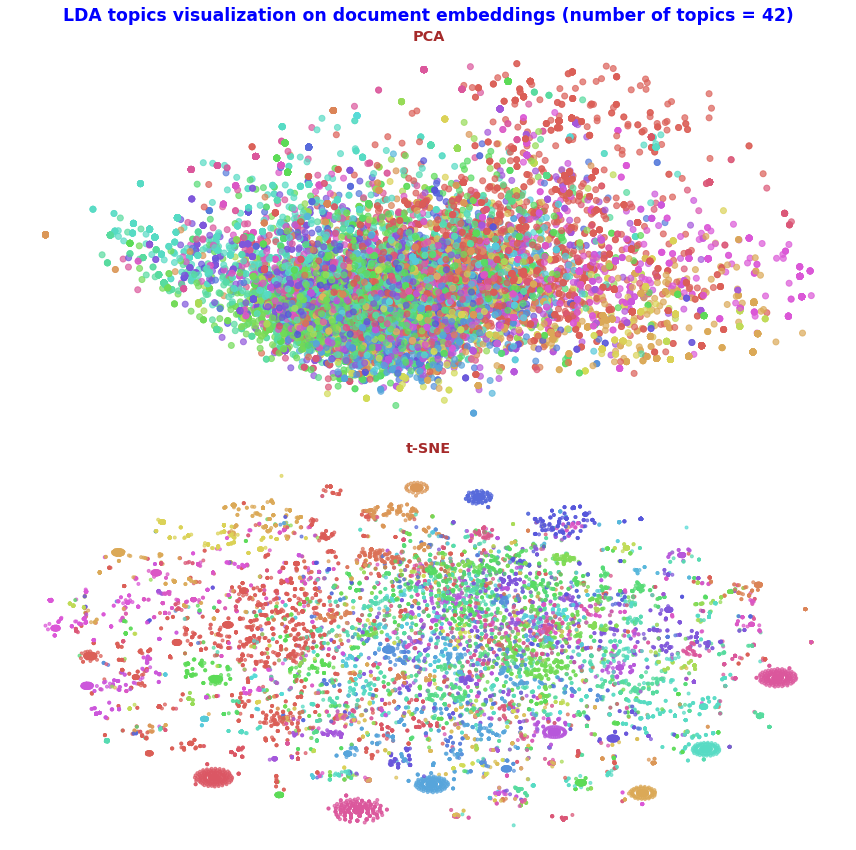

In [87]:
%%time
plot_title = f"LDA topics visualization on document embeddings (number of topics = {best_num_topics})"
palette = sns.color_palette("hls", as_cmap=True)
colors = topic_num / best_num_topics

# Visualize clusters with PCA and t-SNE
visualize_cluster(plot_title, (12,12), colors, palette, pca_datapoint_raw, tsne_datapoint_raw, pca=True, tsne=True)

## Save cluster results to file

In [75]:
df_dominant_topic.to_csv(OUTPUT_DIR + "job-title_dominant-topic_lda.csv", index=False)

In [76]:
sent_topics_sorted_df.to_csv(
    OUTPUT_DIR + "job-title_represent-doc-per-topic_lda.csv", index=False
)

In [83]:
df_dominant_topics.to_csv(
    OUTPUT_DIR + "job-title_topic-distribution_lda.csv", index=False
)